In [1]:
from robustbench.data import load_cifar10c
from robustbench.data import load_cifar10, load_imagenet
from robustbench.utils import clean_accuracy
from robustbench.utils import load_model
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

In [2]:
model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval()
x_clean,y_clean = load_cifar10(10000)

CORRUPTIONS = ["gaussian_noise","shot_noise","impulse_noise", 
               "defocus_blur","glass_blur","motion_blur","zoom_blur",
               "snow","frost", "fog",
               "brightness", "contrast","elastic_transform","pixelate","jpeg_compression"]
imgs_per_corr = 10000
x_corr,y_corr = load_cifar10c(imgs_per_corr*len(CORRUPTIONS),5,corruptions=CORRUPTIONS,data_dir='/home/gc28692/Projects/data/')

Files already downloaded and verified


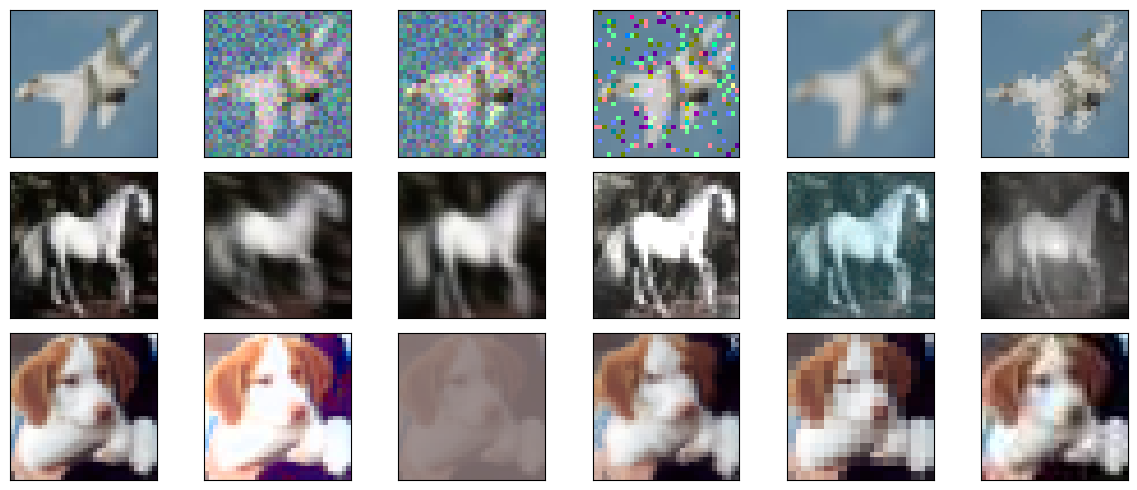

In [3]:
fig,ax = plt.subplots(3,6,figsize=(12,5))
for row in range(3):
    idx = row*3+10
    ax[row,0].imshow(x_clean[idx].permute(1,2,0))
    ax[row,0].set_xticks([])
    ax[row,0].set_yticks([])
    for col in range(1,6):
        ax[row,col].imshow(x_corr[idx+10000*(row*5+col-1)].permute(1,2,0))
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
fig.tight_layout()

In [4]:
fig.savefig("dist.svg")

In [13]:
# clean
eval_results = {corr: 0 for corr in ['clean'] + CORRUPTIONS}
eval_results['clean'] = clean_accuracy(model.to('cuda'),x_clean,y_clean,256,'cuda')

# corrupted
for corr_i,corr in enumerate(CORRUPTIONS):
    s = corr_i*imgs_per_corr
    e = s + imgs_per_corr
    eval_results[corr] = clean_accuracy(model.to('cuda'),x_corr[s:e],y_corr[s:e],256,'cuda')
print(eval_results)
df = pd.DataFrame(eval_results,index=[0])
df.to_csv("corruption_accuracies.csv")

{'clean': 0.9477, 'gaussian_noise': 0.2767, 'shot_noise': 0.3429, 'impulse_noise': 0.2708, 'defocus_blur': 0.5305, 'glass_blur': 0.4567, 'motion_blur': 0.6524, 'zoom_blur': 0.5798, 'snow': 0.7491, 'frost': 0.5869, 'fog': 0.74, 'brightness': 0.9069, 'contrast': 0.533, 'elastic_transform': 0.7341, 'pixelate': 0.4155, 'jpeg_compression': 0.697}


(0.0, 1.0)

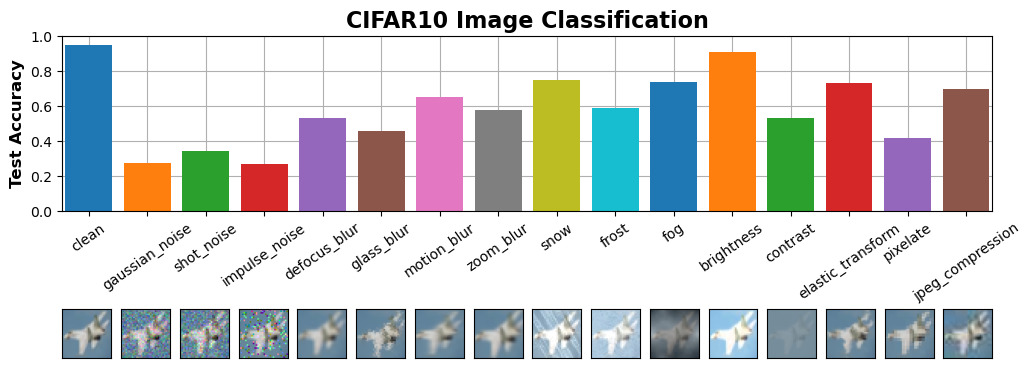

In [36]:
eval_results = dict(pd.read_csv("corruption_accuracies.csv"))
fig,ax = plt.subplot_mosaic([['bar']*16,#['bar','bar','bar','bar','bar','bar'],
                             ['clean']+CORRUPTIONS],
                             #['clean','frost','gaussian_noise','glass_blur','contrast','pixelate']],
                            figsize=(12,5))
x = list(eval_results.keys())
y = list(eval_results.values())

#corrs = ['clean','frost','gaussian_noise','glass_blur','contrast','pixelate']
corrs = ['clean'] + CORRUPTIONS
for corr, val, in zip(x,y):
    if corr in corrs:
        ax['bar'].bar(corr,val)#,width = 0.75,align='center')
        # ax['bar'].set_xticks(corrs,corrs,fontsize=14, fontweight='bold')
        # ax['bar'].set_yticks(corrs,corrs,fontsize=14, fontweight='bold')
        margin = (1 - 0.1) + 0.1 / 2
        ax['bar'].set_xlim(-margin+0.5, 16 - 1 + margin-0.5)
        if corr == 'clean':
            ax[corr].imshow(x_clean[10].permute(1,2,0))
        else:
            idx = CORRUPTIONS.index(corr)
            ax[corr].imshow(x_corr[10+10000*idx].permute(1,2,0))
        ax[corr].set_xticks([])
        ax[corr].set_yticks([])
        ax['bar'].tick_params(axis='x', rotation=35)
ax['bar'].grid()
ax['bar'].set_axisbelow(True)
ax['bar'].set_ylabel("Test Accuracy",fontsize=12,fontweight='bold')
ax['bar'].set_title("CIFAR10 Image Classification",fontsize=16,fontweight='bold')
ax['bar'].set_ylim((0,1))

In [37]:
fig.savefig("corr.svg")

In [140]:
from corruption_funcs import *

In [141]:
import torchvision.transforms as trn
convert_img = trn.Compose([trn.ToPILImage()])

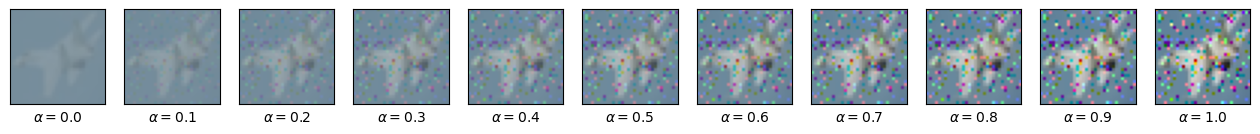

In [131]:
fig,ax = plt.subplots(1,11,figsize=(16,8))
img = convert_img(x_clean[10])
gn = np.uint8(impulse_noise(img,5))
ct = np.uint8(contrast(img,5))
gb = np.uint8(glass_blur(img,5))
px = np.uint8(pixelate(img,5))
# ft = np.uint8(frost(img,5))
alpha = 1

for i in range(11):
    alpha = i/10
    new_img = np.uint8(alpha*gn+(1-alpha)*ct)
    ax[i].imshow(new_img)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_xlabel(r"$\alpha=$"+str(alpha))


In [20]:
import sys
sys.path.append("../")
sys.path.append("../finetuning")
from finetuning.datasets import *
from finetuning.train import validate
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch

def put_back_params(model,params):
    with torch.no_grad():
        weights = params[:len(params)//2]
        biases = params[len(params)//2:]
        model.bn1.weight[:] = weights[:]
        model.bn1.bias[:] = biases[:]
        return model

# root_dir = '../saved_data/checkpoints/gen_last_bn_eval_diverse/contrast'
# root_dir = '../saved_data/checkpoints/train_all/frost'
pt = "/home/gc28692/Projects/GenAIProject/saved_data/checkpoints/train_all/frost/seed123_2024-04-15 16:08:55.pth"
# files = os.listdir(root_dir)
# ck = torch.load(os.path.join(root_dir,files[0]))

# vec = torch.cat([param.flatten() for param in ck['model_state_dict'].values()]).to('cpu')
# vecs = torch.zeros(1,vec.shape[0])
# for i in range(1):
#     ck = torch.load(os.path.join(root_dir,files[i]))
#     vecs[i,:] = torch.cat([param.flatten() for param in ck['model_state_dict'].values()]).to('cpu')

model = load_model(model_name='Standard',dataset='cifar10',threat_model='corruptions').eval()
# model = put_back_params(model,vecs[0])
model.load_state_dict(torch.load(pt)['model_state_dict'])
# model.load_state_dict(sd,strict=False)
model = model.eval()
# train_ds, val_ds, test_ds = get_cifar10c_data([dls.vocab[yb[0]]],1000)
train_ds, val_ds, test_ds = get_cifar10c_data(['glass_blur'],1000)
dl_t = DataLoader(test_ds,batch_size=256)
criterion = nn.CrossEntropyLoss()

validate(model,dl_t,'cuda',criterion)

100%|██████████| 35/35 [00:03<00:00,  9.66it/s]


(0.7146590909090909, tensor(0.9201, device='cuda:0'))

In [146]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, td, corr1, corr2, toimg, totens, alpha):
        self.td = td
        self.corr1 = corr1
        self.corr2 = corr2
        self.totens = totens
        self.toimg = toimg
        self.alpha = alpha

    def __getitem__(self, index):
        x,y = self.td[index]
        x = self.toimg(x)
        x1 = self.corr1(x,5)
        x2 = self.corr2(x,5)
        x = self.totens(np.uint8(self.alpha*x1 + (1-self.alpha)*x2))

        return x, y

    def __len__(self):
        return len(self.td)
    


In [147]:

alphas = np.linspace(0,1,5)
gn_accs = []
for alpha in alphas:
    tensd = CustomTensorDataset(TensorDataset(x_clean,y_clean), gaussian_noise,contrast,convert_img,trn.ToTensor(),alpha)
    dl_t = DataLoader(tensd,batch_size=256)
    criterion = nn.CrossEntropyLoss()

    acc, _ = validate(model,dl_t,'cuda',criterion)
    gn_accs.append(acc)

100%|██████████| 40/40 [00:06<00:00,  6.28it/s]


In [149]:
ct_accs = []
for alpha in alphas:
    tensd = CustomTensorDataset(TensorDataset(x_clean,y_clean), gaussian_noise,contrast,convert_img,trn.ToTensor(),alpha)
    dl_t = DataLoader(tensd,batch_size=256)
    criterion = nn.CrossEntropyLoss()

    acc, _ = validate(model,dl_t,'cuda',criterion)
    ct_accs.append(acc)

100%|██████████| 40/40 [00:06<00:00,  6.47it/s]


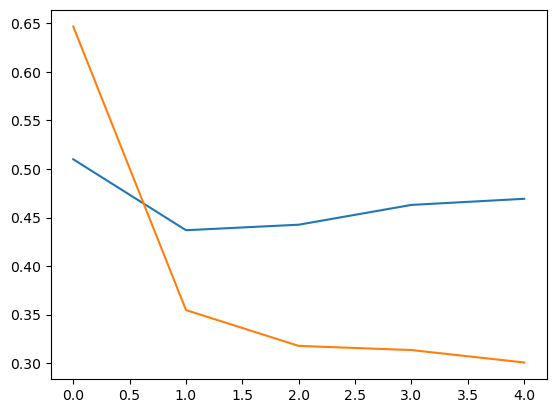

In [151]:
plt.plot(gn_accs)
plt.plot(ct_accs)

In [ ]:
from denoising_diffusion_pytorch.denoising_diffusion_pytorch_1d import 